In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import xgboost
import lightgbm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score

kfold = KFold(5, shuffle=True, random_state=0)

In [2]:
def get_train_df(fold_num):
    train_df = pd.read_csv('Data/pca_projected_506_nc_from_resnet_train.csv')
    #train_df.reset_index(drop=True, inplace=True)
    train_df.head(5)
    train_y = np.array(train_df['is_iceberg']).reshape((train_df.shape[0],))
    
    train_X = pd.read_csv('Data/fine_tune_resnet_extract_features_fold_{}_40_avg_train.csv'.format(fold_num))
    
    print(train_X.shape, train_y.shape)
    return train_X, train_y

In [3]:
def get_feature_num(pca, th):
    counts = pd.Series(pca.explained_variance_ >= th).value_counts(sort=False)
    return counts.values[1]

In [4]:
def get_transformed_df(pca, df):
    new_data = np.array(pca.transform(df))
    columns = ['f_{}'.format(i) for i in range(new_data.shape[1])]
    df = pd.DataFrame(data=new_data,    # values
                  index=df.index,
                  columns=columns)  # 1st row as the column names
    return df, train_y

In [5]:
def get_log_loss(fn, df):
    pca = PCA(whiten=False, svd_solver='full', n_components=fn)
    pca.fit(df)
    
    X, y = get_transformed_df(pca, df)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=519) #should follow how we split data when training resnet
    clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, n_estimators=100, boosting_type='dart')
    log_loss = -1*cross_val_score(clf, X=X, y=y, scoring='neg_log_loss', cv=kfold)
    avg_log_loss = sum(log_loss) / float(len(log_loss))
    
    return avg_log_loss

# Fold 1

In [5]:
train_X, train_y = get_train_df(1)

(1604, 18433) (1604,)


<IPython.core.display.Javascript object>


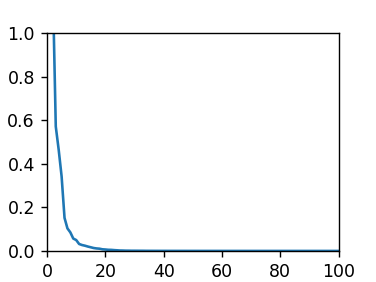

Evaluated components:  18433
Explained variances:  [  5.03285768e+01   5.03883335e+00   1.20916135e+00 ...,   4.86753640e-31
   4.86753640e-31   2.06752678e-32]


In [11]:
pca = PCA(whiten=False, svd_solver='full')
pca.fit(train_X)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)

[8, 19, 29, 52, 98, 173, 304, 487]
[0.17599150493596982, 0.1738523383429818, 0.17290288000820117, 0.17280078952243375, 0.17415637999762174, 0.17191676955637486, 0.17475733740059851, 0.16991157172742266]


<IPython.core.display.Javascript object>


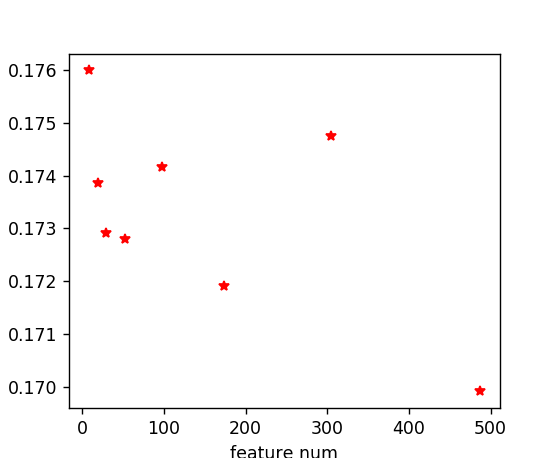

In [17]:
th_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
f_num = [get_feature_num(pca, th) for th in th_list]
cv_scores = [get_log_loss(fn, train_X) for fn in f_num]

print(f_num)
print(cv_scores)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('feature num')
ax.set_ylabel('log loss')
ax.plot(f_num, cv_scores, 'r*')

In [19]:
pca = PCA(whiten=False, svd_solver='full', n_components=487)
pca.fit(train_X)
train_X, train_y = get_transformed_df(pca, train_X)
print(train_X.shape, train_y.shape)

(1604, 487) (1604,)


In [20]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, boosting_type='dart')
params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'learning_rate': 0.05, 'n_estimators': 400} -0.166894948423
    mean_train_score  mean_test_score  std_test_score  \
6          -0.050317        -0.166895        0.040500   
1          -0.043205        -0.167556        0.041360   
0          -0.071731        -0.169924        0.033851   
7          -0.026820        -0.171513        0.050429   
2          -0.028333        -0.172164        0.049507   
5          -0.093444        -0.179329        0.031678   
3          -0.017671        -0.185556        0.059433   
11         -0.134009        -0.202149        0.027511   
4          -0.159571        -0.219300        0.024806   
15         -0.256748        -0.294919        0.016443   
10         -0.270733        -0.306744        0.015413   
9          -0.376385        -0.398824        0.010820   
14         -0.407240        -0.426518        0.009602   
8          -0.463243        -0.477492        0.007323   
13         -0.496488        -0.508251        0.006157   
12         -0.559321       

In [21]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05)
params = {
    'num_leaves': [2, 3, 7, 15, 31, 63],
    'min_split_gain': [.0, .1, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'min_split_gain': 0.0, 'num_leaves': 7} -0.16656462837
    mean_train_score  mean_test_score  std_test_score  \
2          -0.063465        -0.166565        0.037193   
8          -0.063465        -0.166565        0.037193   
14         -0.063465        -0.166565        0.037193   
10         -0.050442        -0.166596        0.041638   
11         -0.050442        -0.166596        0.041638   
4          -0.050317        -0.166895        0.040500   
5          -0.050416        -0.167116        0.040748   
15         -0.050581        -0.167511        0.040290   
16         -0.050314        -0.167543        0.039374   
17         -0.050314        -0.167543        0.039374   
3          -0.050410        -0.167609        0.040522   
9          -0.050541        -0.168291        0.041471   
1          -0.135566        -0.169978        0.029518   
7          -0.135566        -0.169978        0.029518   
13         -0.135566        -0.169978        0.029518   
0          -0.160799        -0.1

In [22]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .8, .6, .4, .2],
    'colsample_bytree': [1., .8, .6, .4, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 1.0, 'subsample': 1.0} -0.16656462837
    mean_train_score  mean_test_score  std_test_score  \
0          -0.063465        -0.166565        0.037193   
1          -0.066054        -0.166784        0.037191   
3          -0.098339        -0.167840        0.034669   
5          -0.069701        -0.168622        0.037762   
2          -0.077316        -0.169516        0.036397   
7          -0.081835        -0.169888        0.034745   
6          -0.071997        -0.170486        0.038496   
8          -0.101386        -0.171278        0.032725   
11         -0.083393        -0.175742        0.036241   
10         -0.082553        -0.176822        0.036640   
12         -0.092272        -0.177166        0.035504   
13         -0.110437        -0.179718        0.033672   
4          -0.139576        -0.180275        0.032977   
9          -0.140773        -0.181190        0.032700   
14         -0.144577        -0.186740        0.033317   
16         -0.104940        -

In [23]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .95, .9, .85],
    'colsample_bytree': [1., .95, .9, .85]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 0.9, 'subsample': 0.95} -0.164124307134
    mean_train_score  mean_test_score  std_test_score  \
9          -0.064918        -0.164124        0.036247   
1          -0.062460        -0.165411        0.036308   
3          -0.064171        -0.165524        0.039964   
13         -0.066033        -0.165784        0.036139   
6          -0.064355        -0.165946        0.038542   
12         -0.066565        -0.165954        0.037489   
2          -0.063410        -0.166038        0.039442   
5          -0.063487        -0.166060        0.036980   
15         -0.067521        -0.166385        0.039109   
11         -0.066763        -0.166420        0.037351   
8          -0.065580        -0.166523        0.038645   
4          -0.064504        -0.166558        0.038426   
0          -0.063465        -0.166565        0.037193   
14         -0.066556        -0.166800        0.036687   
7          -0.065359        -0.167250        0.037870   
10         -0.065694       

In [24]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.9,
                                 subsample=.95)

params = {
    'reg_alpha': [1., .8, .6, .4, .2, .1, .0],
    'reg_lambda': [1., .8, .6, .4, .2, .1, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.0, 'reg_lambda': 0.0} -0.164124307134
    mean_train_score  mean_test_score  std_test_score  \
48         -0.064918        -0.164124        0.036247   
47         -0.065762        -0.165428        0.035612   
31         -0.069788        -0.165488        0.036694   
44         -0.069440        -0.165589        0.036579   
39         -0.067416        -0.165670        0.035366   
41         -0.065834        -0.165710        0.035426   
12         -0.073429        -0.165766        0.034198   
40         -0.066756        -0.165903        0.034933   
33         -0.067553        -0.166062        0.035816   
46         -0.066457        -0.166069        0.035704   
20         -0.070697        -0.166130        0.036046   
32         -0.068345        -0.166178        0.036407   
38         -0.069047        -0.166203        0.036245   
36         -0.071545        -0.166207        0.035192   
45         -0.067889        -0.166339        0.036435   
17         -0.073461        -0.166

In [25]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.9,
                                 subsample=.95)

params = {
    'reg_alpha': [.05, .0],
    'reg_lambda': [.05, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.0, 'reg_lambda': 0.0} -0.164124307134
   mean_train_score  mean_test_score  std_test_score  \
3         -0.064918        -0.164124        0.036247   
0         -0.065642        -0.164745        0.035059   
2         -0.065359        -0.164972        0.036404   
1         -0.065442        -0.166931        0.036126   

                                    params  rank_test_score  
3    {'reg_alpha': 0.0, 'reg_lambda': 0.0}                1  
0  {'reg_alpha': 0.05, 'reg_lambda': 0.05}                2  
2   {'reg_alpha': 0.0, 'reg_lambda': 0.05}                3  
1   {'reg_alpha': 0.05, 'reg_lambda': 0.0}                4  


# Fold 2

In [26]:
train_X, train_y = get_train_df(2)

(1604, 18433) (1604,)


<IPython.core.display.Javascript object>


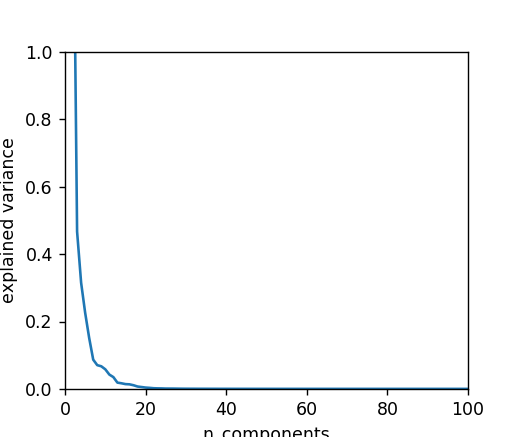

Evaluated components:  18433
Explained variances:  [  5.63713908e+01   3.60547404e+00   1.60867493e+00 ...,   5.46184679e-31
   5.46184679e-31   4.97981330e-31]


In [27]:
pca = PCA(whiten=False, svd_solver='full')
pca.fit(train_X)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)

[7, 18, 25, 45, 85, 146, 251, 390]
[0.13153404274332967, 0.13389019843162986, 0.13361966599334457, 0.13347965639005788, 0.13453436739156743, 0.13071674193276028, 0.13541768151715419, 0.13698690396400875]


<IPython.core.display.Javascript object>


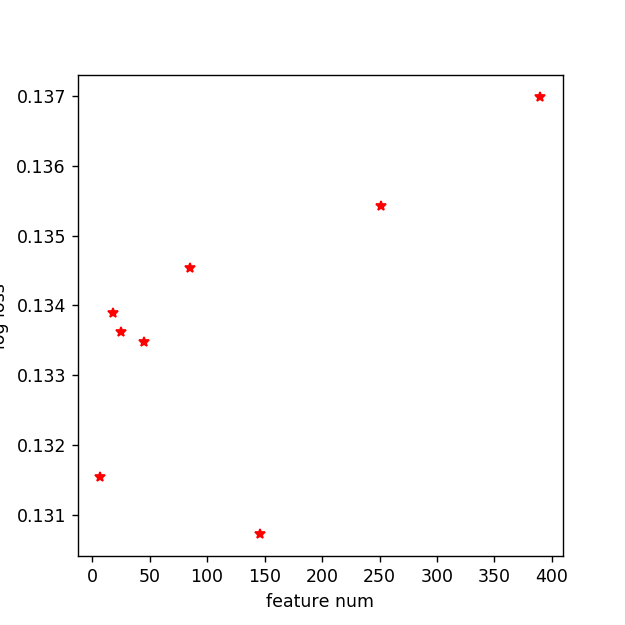

In [28]:
th_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
f_num = [get_feature_num(pca, th) for th in th_list]
cv_scores = [get_log_loss(fn, train_X) for fn in f_num]

print(f_num)
print(cv_scores)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('feature num')
ax.set_ylabel('log loss')
ax.plot(f_num, cv_scores, 'r*')

In [29]:
pca = PCA(whiten=False, svd_solver='full', n_components=146)
pca.fit(train_X)
train_X, train_y = get_transformed_df(pca, train_X)
print(train_X.shape, train_y.shape)

(1604, 146) (1604,)


In [30]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, boosting_type='dart')
params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'learning_rate': 0.05, 'n_estimators': 400} -0.127921585213
    mean_train_score  mean_test_score  std_test_score  \
6          -0.048035        -0.127922        0.010031   
1          -0.042110        -0.128724        0.010657   
0          -0.065921        -0.130719        0.008611   
2          -0.029328        -0.132536        0.012942   
7          -0.027807        -0.135215        0.012506   
5          -0.084215        -0.141112        0.008645   
3          -0.018921        -0.142190        0.014900   
11         -0.122595        -0.166401        0.007340   
4          -0.147218        -0.185600        0.006585   
15         -0.245204        -0.268689        0.004235   
10         -0.259325        -0.281353        0.003992   
9          -0.366577        -0.380178        0.003331   
14         -0.398039        -0.409698        0.003057   
8          -0.455607        -0.463958        0.002389   
13         -0.489915        -0.496711        0.002078   
12         -0.554773       

In [31]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05)
params = {
    'num_leaves': [2, 3, 7, 15, 31, 63],
    'min_split_gain': [.0, .1, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'min_split_gain': 0.1, 'num_leaves': 15} -0.127220419052
    mean_train_score  mean_test_score  std_test_score  \
9          -0.048194        -0.127220        0.009471   
10         -0.048194        -0.127220        0.009471   
11         -0.048194        -0.127220        0.009471   
1          -0.100274        -0.127252        0.009267   
7          -0.100274        -0.127252        0.009267   
13         -0.100274        -0.127252        0.009267   
5          -0.048035        -0.127918        0.010036   
4          -0.048035        -0.127922        0.010031   
15         -0.048272        -0.127996        0.009369   
16         -0.048272        -0.127996        0.009369   
17         -0.048272        -0.127996        0.009369   
2          -0.052159        -0.128088        0.010359   
8          -0.052159        -0.128088        0.010359   
14         -0.052136        -0.128252        0.010475   
3          -0.047896        -0.128434        0.009349   
0          -0.119460        -0

In [32]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=15,
                                 min_split_gain=.1)

params = {
    'subsample': [1., .8, .6, .4, .2],
    'colsample_bytree': [1., .8, .6, .4, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 1.0, 'subsample': 0.8} -0.124163133222
    mean_train_score  mean_test_score  std_test_score  \
1          -0.056417        -0.124163        0.010869   
6          -0.058082        -0.124673        0.011660   
3          -0.086412        -0.125480        0.009175   
7          -0.069409        -0.126639        0.011765   
2          -0.067813        -0.126790        0.011104   
0          -0.048194        -0.127220        0.009471   
8          -0.086579        -0.127692        0.009195   
5          -0.049470        -0.128584        0.009357   
11         -0.063326        -0.131530        0.011953   
10         -0.055048        -0.131942        0.010819   
4          -0.117069        -0.131972        0.008961   
9          -0.116870        -0.133260        0.009389   
12         -0.075209        -0.133296        0.010872   
13         -0.093014        -0.136198        0.009872   
14         -0.117302        -0.138329        0.010066   
15         -0.066035        

In [33]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=15,
                                 min_split_gain=.1)

params = {
    'subsample': [.95, .9, .85, .8, .75, .7, .65],
    'colsample_bytree': [1., .95, .9, .85]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 0.9, 'subsample': 0.65} -0.122751171706
    mean_train_score  mean_test_score  std_test_score  \
20         -0.065113        -0.122751        0.011729   
19         -0.062358        -0.122974        0.012152   
12         -0.061760        -0.123025        0.012854   
4          -0.058430        -0.123343        0.013164   
18         -0.059190        -0.123475        0.012698   
5          -0.061604        -0.123510        0.012114   
13         -0.064696        -0.123744        0.012796   
6          -0.064665        -0.123987        0.013236   
11         -0.058718        -0.124083        0.012464   
3          -0.056417        -0.124163        0.010869   
27         -0.065548        -0.124434        0.011748   
25         -0.059453        -0.124611        0.012073   
24         -0.057228        -0.124685        0.011212   
26         -0.062620        -0.124840        0.011701   
10         -0.056430        -0.125069        0.012072   
17         -0.056884       

In [34]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=15,
                                 min_split_gain=.1,
                                 colsample_bytree=.9,
                                 subsample=.65)

params = {
    'reg_alpha': [1., .8, .6, .4, .2, .1, .0],
    'reg_lambda': [1., .8, .6, .4, .2, .1, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.0, 'reg_lambda': 0.0} -0.122751171706
    mean_train_score  mean_test_score  std_test_score  \
48         -0.065113        -0.122751        0.011729   
34         -0.067315        -0.123454        0.012418   
27         -0.069475        -0.123518        0.011827   
46         -0.066981        -0.123534        0.012665   
39         -0.067981        -0.123684        0.012106   
33         -0.068159        -0.123865        0.011668   
47         -0.066294        -0.123947        0.011712   
24         -0.072271        -0.123966        0.011880   
43         -0.071271        -0.123988        0.011954   
20         -0.071265        -0.124045        0.011739   
38         -0.069455        -0.124056        0.012635   
26         -0.070167        -0.124068        0.012689   
31         -0.070622        -0.124172        0.012339   
41         -0.066382        -0.124200        0.012665   
40         -0.067113        -0.124218        0.011270   
45         -0.068562        -0.124

In [35]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=15,
                                 min_split_gain=.1,
                                 colsample_bytree=.9,
                                 subsample=.65)

params = {
    'reg_alpha': [.05, .0],
    'reg_lambda': [.05, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.0, 'reg_lambda': 0.0} -0.122751171706
   mean_train_score  mean_test_score  std_test_score  \
3         -0.065113        -0.122751        0.011729   
0         -0.066320        -0.123067        0.011748   
1         -0.065948        -0.124038        0.012987   
2         -0.065683        -0.124709        0.012650   

                                    params  rank_test_score  
3    {'reg_alpha': 0.0, 'reg_lambda': 0.0}                1  
0  {'reg_alpha': 0.05, 'reg_lambda': 0.05}                2  
1   {'reg_alpha': 0.05, 'reg_lambda': 0.0}                3  
2   {'reg_alpha': 0.0, 'reg_lambda': 0.05}                4  


# Fold 3

In [36]:
train_X, train_y = get_train_df(3)

(1604, 18433) (1604,)


<IPython.core.display.Javascript object>


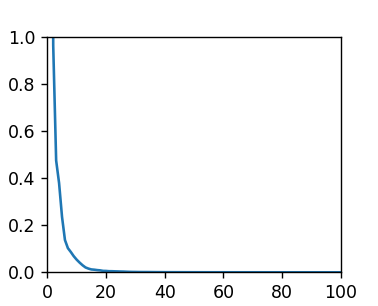

Evaluated components:  18433
Explained variances:  [  5.71372203e+01   5.90359192e+00   9.62479714e-01 ...,   5.48001722e-31
   5.48001722e-31   9.29874454e-32]


In [37]:
pca = PCA(whiten=False, svd_solver='full')
pca.fit(train_X)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)

[8, 17, 36, 73, 147, 262, 425, 581]
[0.15765056252634421, 0.15123567347181785, 0.14875972665647044, 0.15621727715524628, 0.15273476814595255, 0.15817017021277183, 0.15110752743884487, 0.15530465369084495]


<IPython.core.display.Javascript object>


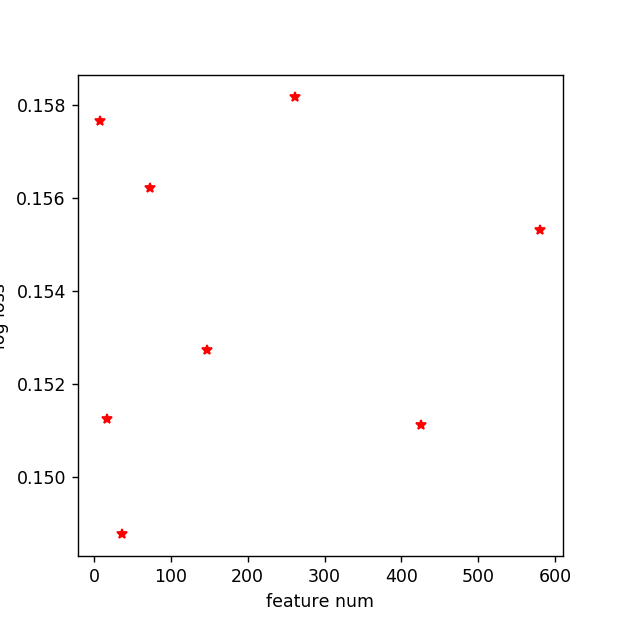

In [38]:
th_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
f_num = [get_feature_num(pca, th) for th in th_list]
cv_scores = [get_log_loss(fn, train_X) for fn in f_num]

print(f_num)
print(cv_scores)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('feature num')
ax.set_ylabel('log loss')
ax.plot(f_num, cv_scores, 'r*')

In [39]:
pca = PCA(whiten=False, svd_solver='full', n_components=36)
pca.fit(train_X)
train_X, train_y = get_transformed_df(pca, train_X)
print(train_X.shape, train_y.shape)

(1604, 36) (1604,)


In [40]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, boosting_type='dart')
params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'learning_rate': 0.05, 'n_estimators': 400} -0.14510537315
    mean_train_score  mean_test_score  std_test_score  \
6          -0.063939        -0.145105        0.010117   
1          -0.058161        -0.147035        0.011178   
0          -0.081340        -0.148768        0.008988   
2          -0.042700        -0.153080        0.013275   
7          -0.040934        -0.154146        0.011202   
5          -0.100081        -0.158493        0.007859   
3          -0.027421        -0.164565        0.014725   
11         -0.137332        -0.181951        0.006220   
4          -0.160963        -0.200607        0.006016   
15         -0.257037        -0.281459        0.005727   
10         -0.270810        -0.293694        0.005652   
9          -0.375316        -0.388997        0.004301   
14         -0.405982        -0.417805        0.003815   
8          -0.461880        -0.470883        0.002981   
13         -0.495221        -0.502663        0.002416   
12         -0.558344        

In [41]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05)
params = {
    'num_leaves': [2, 3, 7, 15, 31, 63],
    'min_split_gain': [.0, .1, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'min_split_gain': 0.2, 'num_leaves': 7} -0.144077906557
    mean_train_score  mean_test_score  std_test_score  \
14         -0.073931        -0.144078        0.010934   
2          -0.073920        -0.144124        0.010972   
8          -0.073920        -0.144124        0.010972   
4          -0.063939        -0.145105        0.010117   
5          -0.063939        -0.145105        0.010117   
15         -0.064597        -0.145490        0.010688   
9          -0.064081        -0.145749        0.010941   
3          -0.064212        -0.145757        0.010841   
16         -0.064631        -0.145938        0.010300   
17         -0.064631        -0.145938        0.010300   
10         -0.064131        -0.146054        0.010095   
11         -0.064131        -0.146054        0.010095   
1          -0.121692        -0.146118        0.012277   
7          -0.121692        -0.146118        0.012277   
13         -0.121692        -0.146118        0.012277   
0          -0.139779        -0.

In [42]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .8, .6, .4, .2],
    'colsample_bytree': [1., .8, .6, .4, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 1.0, 'subsample': 1.0} -0.144077906557
    mean_train_score  mean_test_score  std_test_score  \
0          -0.073931        -0.144078        0.010934   
1          -0.075555        -0.144138        0.013177   
5          -0.077577        -0.145690        0.010977   
6          -0.079182        -0.146068        0.012159   
2          -0.087107        -0.146533        0.012281   
8          -0.106571        -0.147020        0.014116   
7          -0.088938        -0.147065        0.013443   
3          -0.105973        -0.147462        0.011998   
10         -0.087564        -0.149276        0.010304   
11         -0.088829        -0.150706        0.011964   
13         -0.111691        -0.151924        0.013536   
12         -0.095791        -0.152506        0.012269   
4          -0.136314        -0.153953        0.012366   
9          -0.135647        -0.156184        0.014311   
14         -0.137215        -0.156909        0.011653   
15         -0.107920        

In [43]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .95, .9, .85],
    'colsample_bytree': [1., .95, .9, .85]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 0.95, 'subsample': 1.0} -0.143949909232
    mean_train_score  mean_test_score  std_test_score  \
4          -0.073997        -0.143950        0.011708   
0          -0.073931        -0.144078        0.010934   
8          -0.074603        -0.144360        0.010666   
13         -0.075623        -0.144445        0.012063   
12         -0.076018        -0.144733        0.010985   
9          -0.074003        -0.145095        0.011424   
1          -0.072469        -0.145119        0.012329   
7          -0.074206        -0.145304        0.011899   
10         -0.074270        -0.145430        0.012865   
14         -0.076146        -0.145441        0.012519   
3          -0.073698        -0.145537        0.011546   
5          -0.073050        -0.145733        0.012323   
6          -0.073364        -0.146461        0.013959   
15         -0.076430        -0.146465        0.010611   
2          -0.072964        -0.146573        0.013343   
11         -0.075101       

In [44]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=1.)

params = {
    'reg_alpha': [1., .8, .6, .4, .2, .1, .0],
    'reg_lambda': [1., .8, .6, .4, .2, .1, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.1, 'reg_lambda': 0.4} -0.14330916414
    mean_train_score  mean_test_score  std_test_score  \
38         -0.077254        -0.143309        0.011095   
26         -0.078105        -0.143535        0.010471   
45         -0.076400        -0.143548        0.012238   
41         -0.074612        -0.143627        0.011050   
33         -0.076011        -0.143656        0.010613   
23         -0.081111        -0.143702        0.009862   
42         -0.079656        -0.143740        0.010192   
40         -0.075497        -0.143750        0.010873   
27         -0.077350        -0.143794        0.011632   
46         -0.075114        -0.143808        0.011292   
31         -0.077931        -0.143833        0.010624   
32         -0.076691        -0.143834        0.011205   
20         -0.079798        -0.143871        0.010692   
25         -0.078529        -0.143890        0.011767   
47         -0.074467        -0.143923        0.011289   
18         -0.080836        -0.1439

In [45]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=1.)

params = {
    'reg_alpha': [.15, .1, .05],
    'reg_lambda': [.55, .5, .45, .4, .35, .3]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.05, 'reg_lambda': 0.55} -0.142982378551
    mean_train_score  mean_test_score  std_test_score  \
12         -0.077671        -0.142982        0.011243   
9          -0.077254        -0.143309        0.011095   
16         -0.076464        -0.143331        0.010399   
10         -0.076663        -0.143458        0.010719   
7          -0.077603        -0.143638        0.010883   
5          -0.076652        -0.143666        0.012079   
4          -0.077168        -0.143682        0.011429   
14         -0.076831        -0.143690        0.010447   
3          -0.077477        -0.143779        0.011132   
15         -0.076561        -0.143808        0.010828   
13         -0.077379        -0.143862        0.010946   
17         -0.075909        -0.143958        0.011248   
11         -0.076356        -0.143970        0.011315   
8          -0.077177        -0.143974        0.011841   
2          -0.077700        -0.144063        0.011328   
0          -0.078354        -0.1

# Fold 4

In [50]:
train_X, train_y = get_train_df(4)

(1604, 18433) (1604,)


<IPython.core.display.Javascript object>


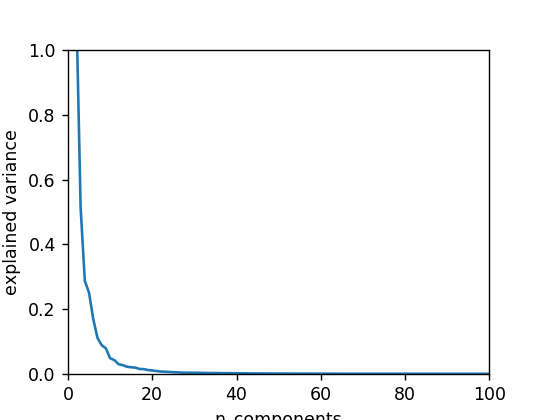

Evaluated components:  18433
Explained variances:  [  4.80529652e+01   6.54375882e+00   1.12885704e+00 ...,   6.00409813e-19
   5.37822992e-19   1.32353579e-32]


In [47]:
pca = PCA(whiten=False, svd_solver='full')
pca.fit(train_X)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)

[8, 21, 47, 94, 174, 299, 480, 689]
[0.1765731121984167, 0.17831066865282383, 0.16764102235578013, 0.17049783438623672, 0.17029298200184945, 0.1750451884236281, 0.17280043975208376, 0.17042055802606154]


<IPython.core.display.Javascript object>


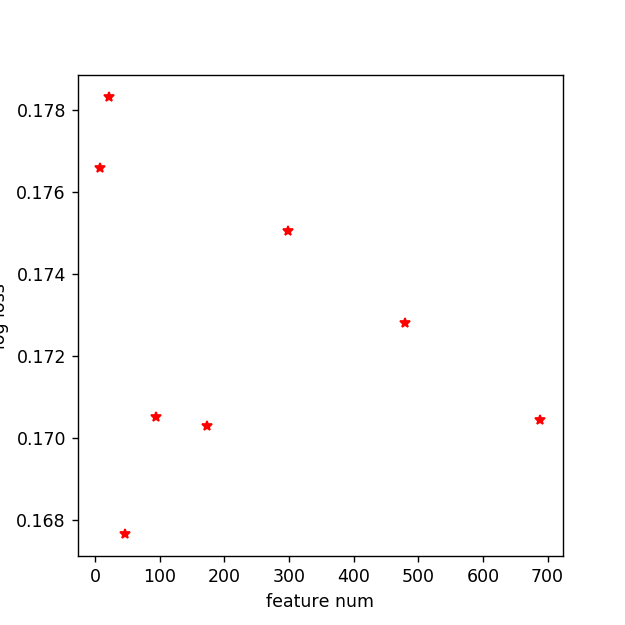

In [48]:
th_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
f_num = [get_feature_num(pca, th) for th in th_list]
cv_scores = [get_log_loss(fn, train_X) for fn in f_num]

print(f_num)
print(cv_scores)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('feature num')
ax.set_ylabel('log loss')
ax.plot(f_num, cv_scores, 'r*')

In [51]:
pca = PCA(whiten=False, svd_solver='full', n_components=47)
pca.fit(train_X)
train_X, train_y = get_transformed_df(pca, train_X)
print(train_X.shape, train_y.shape)

(1604, 47) (1604,)


In [52]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, boosting_type='dart')
params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'learning_rate': 0.05, 'n_estimators': 400} -0.165934660208
    mean_train_score  mean_test_score  std_test_score  \
6          -0.071119        -0.165935        0.031854   
1          -0.063470        -0.165992        0.033515   
0          -0.089591        -0.167656        0.028074   
2          -0.045688        -0.172617        0.039713   
7          -0.043591        -0.173800        0.039452   
5          -0.109883        -0.175697        0.023860   
3          -0.028490        -0.182198        0.045982   
11         -0.147443        -0.197964        0.020051   
4          -0.171150        -0.215111        0.018368   
15         -0.265097        -0.291907        0.012509   
10         -0.278529        -0.303754        0.011926   
9          -0.381746        -0.397384        0.008575   
14         -0.411976        -0.425398        0.007899   
8          -0.467064        -0.476856        0.006014   
13         -0.499807        -0.507967        0.005043   
12         -0.561463       

In [53]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05)
params = {
    'num_leaves': [2, 3, 7, 15, 31, 63],
    'min_split_gain': [.0, .1, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'min_split_gain': 0.0, 'num_leaves': 7} -0.163852826427
    mean_train_score  mean_test_score  std_test_score  \
2          -0.091842        -0.163853        0.030720   
8          -0.091842        -0.163853        0.030720   
14         -0.091842        -0.163853        0.030720   
3          -0.071430        -0.164833        0.031528   
16         -0.071642        -0.164970        0.031468   
17         -0.071642        -0.164970        0.031468   
10         -0.070954        -0.165261        0.031203   
11         -0.070954        -0.165261        0.031203   
9          -0.071557        -0.165591        0.032195   
5          -0.071109        -0.165752        0.031627   
4          -0.071119        -0.165935        0.031854   
15         -0.071537        -0.166182        0.030927   
1          -0.147345        -0.168919        0.027040   
7          -0.147345        -0.168919        0.027040   
13         -0.147345        -0.168919        0.027040   
0          -0.165653        -0.

In [54]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .8, .6, .4, .2],
    'colsample_bytree': [1., .8, .6, .4, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 1.0, 'subsample': 0.8} -0.162686681674
    mean_train_score  mean_test_score  std_test_score  \
1          -0.089581        -0.162687        0.030661   
0          -0.091842        -0.163853        0.030720   
2          -0.098709        -0.164024        0.030425   
5          -0.097888        -0.165881        0.031932   
7          -0.102951        -0.165965        0.030777   
6          -0.095961        -0.167097        0.031702   
3          -0.119169        -0.167701        0.030190   
8          -0.122396        -0.169678        0.031082   
10         -0.108398        -0.172472        0.029928   
12         -0.111657        -0.174063        0.031051   
11         -0.106851        -0.174068        0.029737   
13         -0.128100        -0.174512        0.029157   
4          -0.153098        -0.176649        0.026307   
9          -0.153863        -0.178545        0.027338   
14         -0.159373        -0.184177        0.025268   
16         -0.129205        

In [55]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [.95, .9, .85, .8, .75, .7, .65],
    'colsample_bytree': [1., .95, .9, .85]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 0.95, 'subsample': 0.8} -0.161493383361
    mean_train_score  mean_test_score  std_test_score  \
10         -0.090045        -0.161493        0.030719   
17         -0.091381        -0.161637        0.031025   
4          -0.091006        -0.162670        0.031796   
3          -0.089581        -0.162687        0.030661   
20         -0.096222        -0.162879        0.031631   
16         -0.091236        -0.162945        0.032401   
5          -0.092596        -0.163341        0.030777   
6          -0.094499        -0.163764        0.031831   
12         -0.093184        -0.163807        0.031285   
1          -0.088980        -0.163828        0.031957   
11         -0.091408        -0.163835        0.031146   
18         -0.092960        -0.163927        0.032507   
8          -0.089679        -0.163949        0.031285   
15         -0.091098        -0.164060        0.032052   
7          -0.090413        -0.164082        0.030920   
19         -0.093954       

In [56]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=.8)

params = {
    'reg_alpha': [1., .8, .6, .4, .2, .1, .0],
    'reg_lambda': [1., .8, .6, .4, .2, .1, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.2, 'reg_lambda': 0.0} -0.161453774074
    mean_train_score  mean_test_score  std_test_score  \
34         -0.092086        -0.161454        0.029592   
48         -0.090045        -0.161493        0.030719   
39         -0.092632        -0.161585        0.029792   
46         -0.091706        -0.161876        0.030236   
40         -0.092060        -0.162209        0.029919   
33         -0.092819        -0.162296        0.029878   
44         -0.094709        -0.162420        0.030296   
45         -0.093147        -0.162552        0.029983   
32         -0.093386        -0.162722        0.030726   
47         -0.091030        -0.162758        0.029708   
20         -0.096577        -0.162867        0.029989   
41         -0.091272        -0.163010        0.030079   
36         -0.096946        -0.163066        0.030038   
30         -0.096881        -0.163244        0.030170   
26         -0.094829        -0.163292        0.030252   
31         -0.095481        -0.163

In [57]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=.8)

params = {
    'reg_alpha': [.35, .3, .2, .15],
    'reg_lambda': [.05, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.2, 'reg_lambda': 0.0} -0.161453774074
   mean_train_score  mean_test_score  std_test_score  \
5         -0.092086        -0.161454        0.029592   
4         -0.092566        -0.161955        0.030057   
2         -0.093639        -0.162660        0.029648   
6         -0.092071        -0.162727        0.030491   
3         -0.093161        -0.163142        0.030617   
7         -0.091682        -0.163145        0.029985   
1         -0.093649        -0.163550        0.031076   
0         -0.094093        -0.163808        0.030198   

                                    params  rank_test_score  
5    {'reg_alpha': 0.2, 'reg_lambda': 0.0}                1  
4   {'reg_alpha': 0.2, 'reg_lambda': 0.05}                2  
2   {'reg_alpha': 0.3, 'reg_lambda': 0.05}                3  
6  {'reg_alpha': 0.15, 'reg_lambda': 0.05}                4  
3    {'reg_alpha': 0.3, 'reg_lambda': 0.0}                5  
7   {'reg_alpha': 0.15, 'reg_lambda': 0.0}                6  
1   {'r

# Fold 5

In [58]:
train_X, train_y = get_train_df(5)

(1604, 18433) (1604,)


<IPython.core.display.Javascript object>


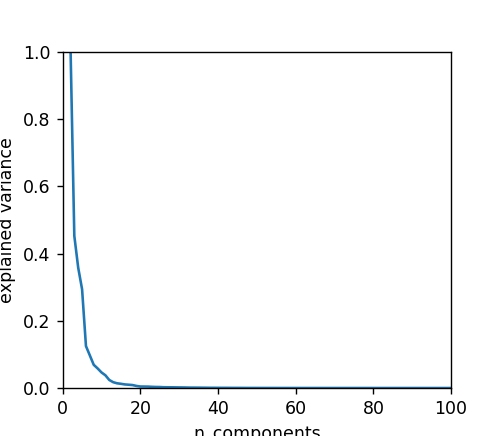

Evaluated components:  18433
Explained variances:  [  4.92431490e+01   5.35313506e+00   1.02745165e+00 ...,   4.79552132e-31
   4.79552132e-31   6.12518896e-32]


In [59]:
pca = PCA(whiten=False, svd_solver='full')
pca.fit(train_X)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_ylim(0,1.0)
ax.set_xlim(0,100)
ax.plot(pca.explained_variance_)
print("Evaluated components: ", pca.n_components_ )
print("Explained variances: ", pca.explained_variance_)

[7, 17, 36, 56, 106, 177, 280, 401]
[0.16019853205052229, 0.16057787847473576, 0.15293227323844466, 0.15444665141603292, 0.15472987369385144, 0.15694229922686448, 0.15698772758845592, 0.15736684412800178]


<IPython.core.display.Javascript object>


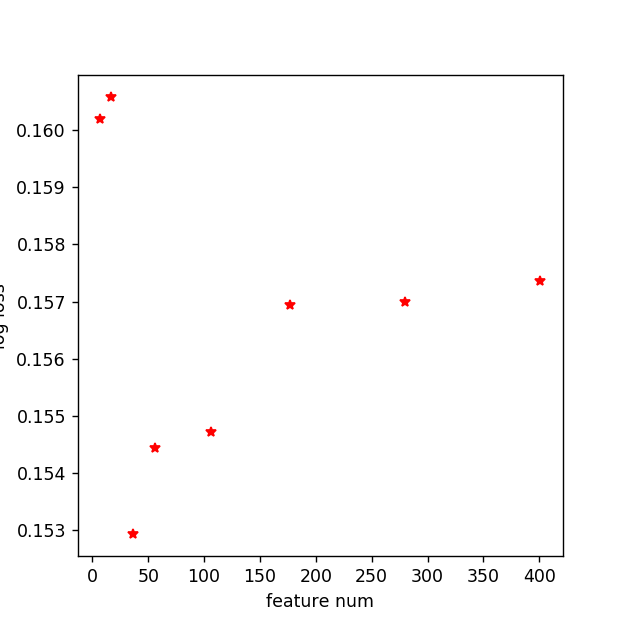

In [60]:
th_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
f_num = [get_feature_num(pca, th) for th in th_list]
cv_scores = [get_log_loss(fn, train_X) for fn in f_num]

print(f_num)
print(cv_scores)

%matplotlib notebook
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('feature num')
ax.set_ylabel('log loss')
ax.plot(f_num, cv_scores, 'r*')

In [61]:
pca = PCA(whiten=False, svd_solver='full', n_components=36)
pca.fit(train_X)
train_X, train_y = get_transformed_df(pca, train_X)
print(train_X.shape, train_y.shape)

(1604, 36) (1604,)


In [62]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, objective='binary', random_state=0, boosting_type='dart')
params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'learning_rate': 0.1, 'n_estimators': 400} -0.143286003116
    mean_train_score  mean_test_score  std_test_score  \
2          -0.041113        -0.143286        0.036151   
7          -0.039192        -0.143652        0.035534   
6          -0.064172        -0.144700        0.031711   
1          -0.057120        -0.144943        0.032265   
3          -0.026289        -0.147641        0.038323   
0          -0.083726        -0.152930        0.027859   
5          -0.102454        -0.161417        0.026508   
11         -0.140192        -0.185768        0.021829   
4          -0.163480        -0.203898        0.020156   
15         -0.258315        -0.282832        0.014633   
10         -0.272035        -0.294855        0.013991   
9          -0.376695        -0.390126        0.010187   
14         -0.407242        -0.418697        0.009044   
8          -0.463065        -0.471472        0.006987   
13         -0.496333        -0.503168        0.005906   
12         -0.559226        

In [63]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1)
params = {
    'num_leaves': [2, 3, 7, 15, 31, 63],
    'min_split_gain': [.0, .1, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'min_split_gain': 0.2, 'num_leaves': 7} -0.140664877123
    mean_train_score  mean_test_score  std_test_score  \
14         -0.043819        -0.140665        0.035728   
2          -0.044031        -0.141837        0.036379   
8          -0.043999        -0.141844        0.036380   
3          -0.041295        -0.141976        0.035029   
10         -0.041165        -0.142621        0.036449   
11         -0.041165        -0.142621        0.036449   
9          -0.041155        -0.142843        0.036998   
15         -0.041157        -0.143000        0.036309   
4          -0.041113        -0.143286        0.036151   
16         -0.041292        -0.143803        0.035586   
17         -0.041292        -0.143803        0.035586   
1          -0.099744        -0.143982        0.028882   
7          -0.099744        -0.143982        0.028882   
13         -0.099744        -0.143982        0.028882   
5          -0.041241        -0.144025        0.036475   
0          -0.127528        -0.

In [64]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [1., .8, .6, .4, .2],
    'colsample_bytree': [1., .8, .6, .4, .2]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 1.0, 'subsample': 0.8} -0.139392476797
    mean_train_score  mean_test_score  std_test_score  \
1          -0.049572        -0.139392        0.032998   
0          -0.043819        -0.140665        0.035728   
6          -0.049938        -0.141546        0.032297   
2          -0.062807        -0.142175        0.032876   
11         -0.052243        -0.142550        0.033591   
7          -0.063503        -0.142631        0.035697   
12         -0.065512        -0.143047        0.033061   
5          -0.044423        -0.143278        0.035570   
3          -0.086727        -0.143692        0.035207   
13         -0.088386        -0.144288        0.031012   
10         -0.046253        -0.144986        0.035309   
15         -0.052784        -0.146054        0.031513   
16         -0.057790        -0.146059        0.032799   
8          -0.087517        -0.146845        0.034251   
17         -0.069521        -0.147728        0.032986   
18         -0.091148        

In [65]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 num_leaves=7,
                                 min_split_gain=.2)

params = {
    'subsample': [.95, .9, .85, .8, .75, .7, .65],
    'colsample_bytree': [1., .95, .9, .85]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'colsample_bytree': 0.95, 'subsample': 0.65} -0.139275450903
    mean_train_score  mean_test_score  std_test_score  \
13         -0.058219        -0.139275        0.034227   
3          -0.049572        -0.139392        0.032998   
1          -0.045446        -0.139522        0.034101   
25         -0.052722        -0.139577        0.032344   
12         -0.055353        -0.139861        0.033090   
5          -0.055215        -0.139965        0.032606   
9          -0.047063        -0.140186        0.033222   
10         -0.049624        -0.140280        0.033034   
22         -0.045842        -0.140287        0.033011   
27         -0.059158        -0.140639        0.032571   
14         -0.044435        -0.140684        0.035704   
19         -0.055987        -0.140770        0.031328   
0          -0.044111        -0.140814        0.035158   
4          -0.051973        -0.140897        0.033408   
26         -0.056119        -0.140954        0.031083   
16         -0.047559      

In [66]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=.65)

params = {
    'reg_alpha': [1., .8, .6, .4, .2, .1, .0],
    'reg_lambda': [1., .8, .6, .4, .2, .1, .0]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.1, 'reg_lambda': 0.6} -0.136949415143
    mean_train_score  mean_test_score  std_test_score  \
37         -0.062525        -0.136949        0.031484   
13         -0.066279        -0.137944        0.030548   
32         -0.061554        -0.137951        0.031497   
19         -0.064748        -0.138140        0.031686   
23         -0.065512        -0.138179        0.030738   
29         -0.064795        -0.138291        0.030889   
22         -0.066874        -0.138383        0.031662   
43         -0.063004        -0.138396        0.030858   
28         -0.065710        -0.138544        0.030132   
18         -0.065302        -0.138576        0.030158   
3          -0.070700        -0.138584        0.029578   
2          -0.071878        -0.138750        0.029701   
5          -0.068974        -0.138769        0.031626   
36         -0.063976        -0.138776        0.031896   
35         -0.064998        -0.138814        0.031216   
10         -0.068619        -0.138

In [67]:
lg_clf = lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=.65)

params = {
    'reg_alpha': [1., .95, .9, .85],
    'reg_lambda': [.75, .7, .65, .6, .55, .5, .45]
}

gs = GridSearchCV(lg_clf, params, scoring='neg_log_loss', cv=kfold)
gs.fit(train_X, train_y)
print(gs.best_params_ , gs.best_score_)
cv_df = pd.DataFrame().from_dict(gs.cv_results_)
cv_df = cv_df[['mean_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']]
cv_df.sort_values(by=['rank_test_score', 'std_test_score'], inplace=True)
print(cv_df)

{'reg_alpha': 0.85, 'reg_lambda': 0.6} -0.138218606235
    mean_train_score  mean_test_score  std_test_score  \
24         -0.070076        -0.138219        0.030285   
17         -0.070779        -0.138595        0.029760   
3          -0.071878        -0.138750        0.029701   
13         -0.070046        -0.138850        0.031410   
20         -0.069858        -0.138889        0.031396   
9          -0.071338        -0.139083        0.031152   
1          -0.072217        -0.139259        0.029069   
2          -0.072083        -0.139272        0.029764   
16         -0.070788        -0.139333        0.029802   
27         -0.069268        -0.139381        0.030481   
10         -0.071060        -0.139468        0.030392   
8          -0.071962        -0.139477        0.029649   
11         -0.071185        -0.139514        0.029028   
14         -0.071473        -0.139520        0.029848   
5          -0.071120        -0.139670        0.030300   
0          -0.072517        -0.13

# Generate each solution

In [6]:
n_components = [487, 146, 36, 47, 36]

lg_clfs = [
    lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.9,
                                 subsample=.95),
    lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=15,
                                 min_split_gain=.1,
                                 colsample_bytree=.9,
                                 subsample=.65),
    lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=1.,
                                 reg_alpha=.05,
                                 reg_lambda=.55),
    lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.05,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.95,
                                 subsample=.8),
    lightgbm.LGBMClassifier(n_jobs=4, 
                                 objective='binary', 
                                 random_state=0,
                                 boosting_type='dart',
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 num_leaves=7,
                                 min_split_gain=.2,
                                 colsample_bytree=.85,
                                 subsample=.6)
]

In [7]:
test_df = pd.read_json('Data/test.json')
print(test_df.shape)
test_df.head(5)
test_ids = test_df['id']

(8424, 4)


In [8]:
def get_test_df(fold):
    test_df = pd.read_csv('Data/fine_tune_resnet_extract_features_fold_{}_40_avg_test.csv'.format(fold))
    test_df.sort_index(inplace=True)

    return test_df

In [9]:
for i in range(5):
    fold = i + 1
    train_X, train_y = get_train_df(fold)
    
    pca = PCA(whiten=False, svd_solver='full', n_components=n_components[i])
    pca.fit(train_X)
    train_X, train_y = get_transformed_df(pca, train_X)
    
    clf = lg_clfs[i]
    clf.fit(train_X, train_y)
    
    test_X = get_test_df(fold)
    test_X = pca.transform(test_X)
    predictions = clf.predict_proba(test_X)[:,1]
    print("Fold {} predictions".format(fold), predictions)
    
    submission = pd.DataFrame()
    submission['id'] = test_ids
    submission['is_iceberg'] = predictions
    submission.to_csv('Submissions/submission_lgb_1201_fine_tune_sep_train_fold_{}.csv'.format(fold), 
                      float_format="%.15f", index=False)

(1604, 18433) (1604,)
Fold 1 predictions [ 0.02049846  0.67238682  0.02100156 ...,  0.02691646  0.97695151
  0.01775818]
(1604, 18433) (1604,)
Fold 2 predictions [ 0.00985342  0.92987403  0.01777567 ...,  0.0105333   0.98812005
  0.02190476]
(1604, 18433) (1604,)
Fold 3 predictions [ 0.01052989  0.4465297   0.01432661 ...,  0.00935195  0.98520752
  0.01548719]
(1604, 18433) (1604,)
Fold 4 predictions [ 0.00962795  0.55579353  0.01409126 ...,  0.00937566  0.98712302
  0.01484138]
(1604, 18433) (1604,)
Fold 5 predictions [ 0.0125289   0.8241472   0.0088462  ...,  0.00344118  0.97909584
  0.00856844]
